In [79]:
from OFIT_dir.OFIT import *
from OFIT_dir.parameters import *
from OFIT_dir.transformation import *
import os
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

#retreive images
shot_no = 966
img_dir = r"resources\\TTI frame\\" + f"{shot_no}\\{shot_no}_frames_jpg"


plt.rcParams.update({
    "font.size":15
})
plt.style.use("seaborn-v0_8-dark-palette")

Text(0.5, 1.0, 'raw image of shot number 966 frame 194')

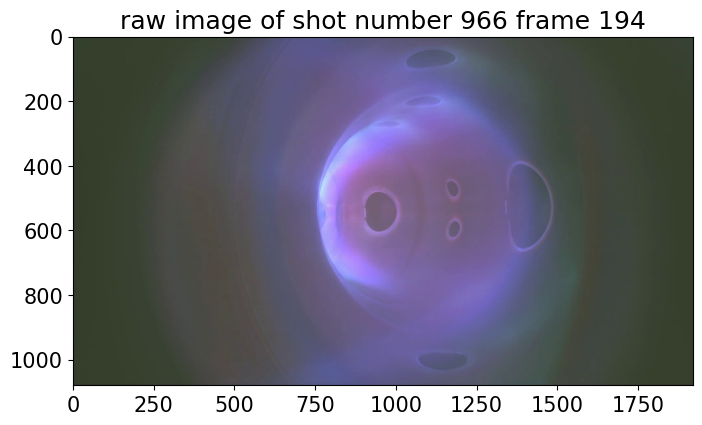

In [50]:
#retreive sample image
frame_no = 194
sample_dir = img_dir + f"\\{frame_no}.jpg"
sample = plt.imread(sample_dir)

fig, ax = plt.subplots(1,1,figsize = (8,6))
ax.imshow(sample)
ax.set_title(f"raw image of shot number {shot_no} frame {frame_no}")

Text(0.5, 1.0, 'edge enhanced masked image')

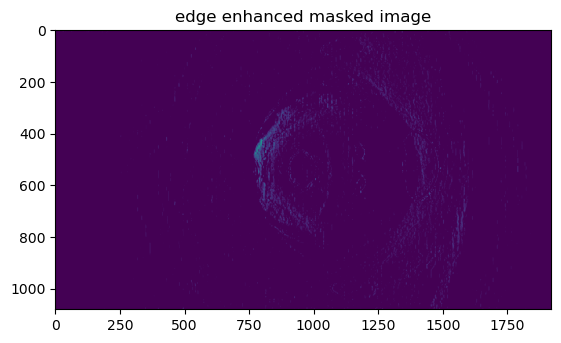

In [37]:
#edge enhanced masked image

masked_sample = process_image(sample)
plt.imshow(masked_sample)
plt.title("edge enhanced masked image")

Text(0.5, 1.0, 'Edge detection result')

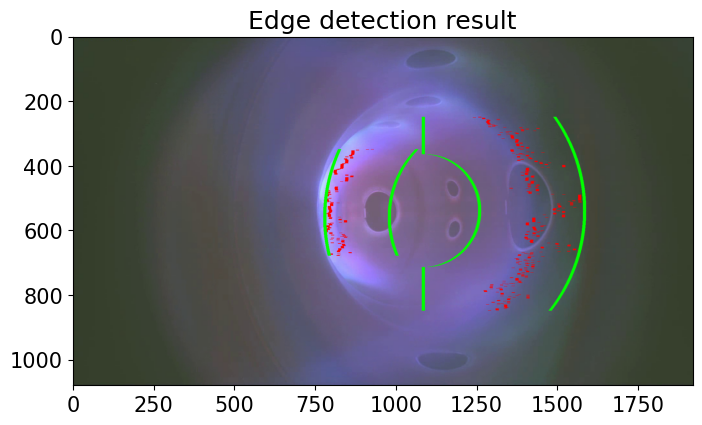

In [103]:
#edge detection result

    # ROI_overlay(shot,TT1_circular_ROIs["ROI_high_x0"],TT1_circular_ROIs["high_row_range"])
    # ROI_overlay(shot,TT1_circular_ROIs["ROI_high_xf"],TT1_circular_ROIs["high_row_range"])

    # ROI_overlay(shot,TT1_circular_ROIs["ROI_low_x0"],TT1_circular_ROIs["low_row_range"])
    # ROI_overlay(shot,TT1_circular_ROIs["ROI_low_xf"],TT1_circular_ROIs["low_row_range"])

(x_high, y_high), (x_low, y_low) = field_edge_detection(masked_sample)

def overlay(x,y,img,color = [255,0,0]):
    copy_img = img.copy()
    for row, column in zip(y,x):
        copy_img[row,column-5:column+5] = color
    return copy_img

edge_detection_img = overlay(x_high,y_high,sample)
edge_detection_img = overlay(x_low,y_low,edge_detection_img)

#overlay ROIs

edge_detection_img = overlay(TT1_circular_ROIs["ROI_high_x0"],TT1_circular_ROIs["high_row_range"],edge_detection_img,color = [0,255,0])
edge_detection_img = overlay(TT1_circular_ROIs["ROI_high_xf"],TT1_circular_ROIs["high_row_range"],edge_detection_img,color = [0,255,0])

edge_detection_img = overlay(TT1_circular_ROIs["ROI_low_x0"],TT1_circular_ROIs["low_row_range"],edge_detection_img,color = [0,255,0])
edge_detection_img = overlay(TT1_circular_ROIs["ROI_low_xf"],TT1_circular_ROIs["low_row_range"],edge_detection_img,color = [0,255,0])


fig, ax = plt.subplots(1,1,figsize = (8,6))
ax.imshow(edge_detection_img)
ax.set_title("Edge detection result")

Text(0.5, 1.0, 'excluded pixels from edge detection')

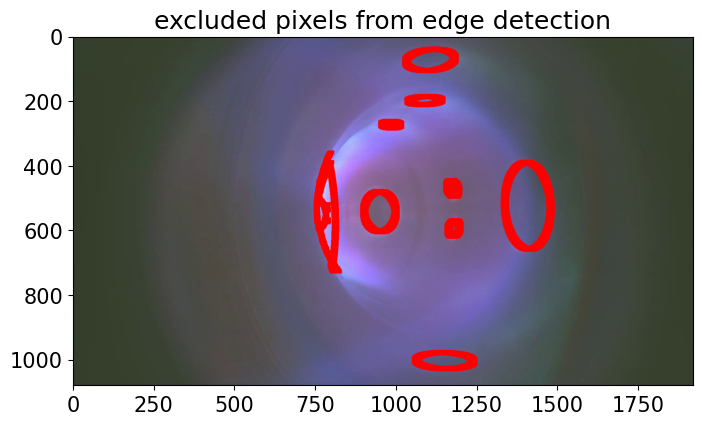

In [54]:
#excluded set
excluded_x, excluded_y = [],[]
for x,y in port_set:
    excluded_x.append(x)
    excluded_y.append(y)

excluded_pixel_img = overlay_edge(excluded_x,excluded_y,sample)

fig, ax = plt.subplots(1,1,figsize = (8,6))

ax.imshow(excluded_pixel_img)
ax.set_title("excluded pixels from edge detection")

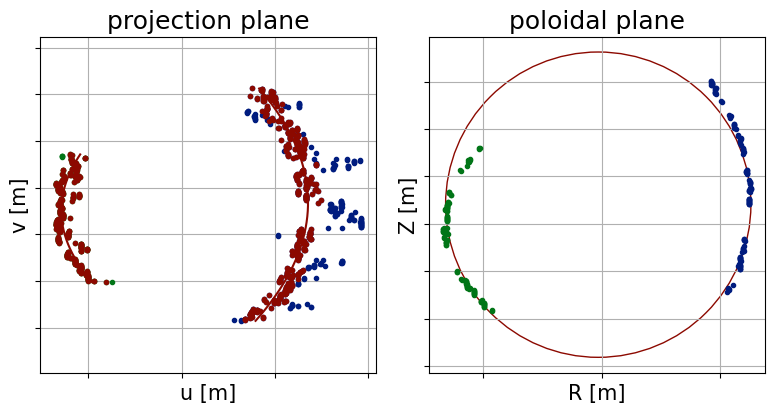

In [99]:
#projection plane with poloidal plane

u_low, v_low = pix_to_projection(x_low,y_low,TT1_projection_matrix,TT1_camera_principle_point)
u_high, v_high = pix_to_projection(x_high,y_high,TT1_projection_matrix,TT1_camera_principle_point)

#parameters of sleeping paraboloa for each axis
low_projection_param,_,best_u_low,best_v_low = RANSAC_parabola(u_low,v_low,epsilon = 0.00005)
high_projection_param,_,best_u_high,best_v_high = RANSAC_parabola(u_high,v_high, epsilon = 0.00005)

#transformation to poloidal plane
R_low, Z_low,_,_,_,_ = poloidal_transformation(u_low,v_low,TT1_camera_translation)
R_high, Z_high,_,_,_,_ = poloidal_transformation(u_high,v_high,TT1_camera_translation)

#combined poloidal points
R_com, Z_com = np.append(R_low,R_high), np.append(Z_low,Z_high)

(R0,Z0,r), *_ = RANSAC_circle(R_com,Z_com)

#plotting

horizontal_parabola = lambda y,a,b,c: a*y**2 + b*y + c

v_min_low,v_max_low = min(v_low), max(v_low)
v_min_high, v_max_high = min(v_high), max(v_high)

#numpy array for ransac
projection_low_arr = np.linspace(v_min_low,v_max_low,300)
projection_high_arr = np.linspace(v_min_high,v_max_high,300)

#fitted param
u_low_fit = horizontal_parabola(v_low,*low_projection_param)
u_high_fit = horizontal_parabola(v_high,*high_projection_param)

fig, ax = plt.subplots(1,2,figsize = (8,6), constrained_layout=True)

ax[0].plot(u_low,v_low,".",label = "low field edge points")
ax[0].plot(u_high,v_high,".",label = "high field edge points")
fit_line, = ax[0].plot(u_low_fit,v_low)
ax[0].plot(u_high_fit,v_high,color = fit_line.get_color())
ax[0].plot(best_u_low,best_v_low,".",color = fit_line.get_color(),label = "edge points within RANSAC residual")
ax[0].plot(best_u_high,best_v_high,".",color = fit_line.get_color())
ax[0].set_title("projection plane")
ax[0].set_xlabel("u [m]")
ax[0].set_ylabel("v [m]")
ax[0].grid()
ax[0].tick_params(labelbottom=False, labelleft=False)
ax[0].set_aspect("equal")

ax[1].plot(R_low,Z_low,".")
ax[1].plot(R_high,Z_high,".")
ax[1].set_title("poloidal plane")
ax[1].set_xlabel("R [m]")
ax[1].set_ylabel("Z [m]")
ax[1].grid()
ax[1].tick_params(labelbottom=False, labelleft=False)
ax[1].set_aspect('equal')

circle = Circle((R0,Z0),r,fill = False,color = fit_line.get_color())
ax[1].add_patch(circle)

ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)


plt.tight_layout()